# Bayesian neural networks and Bayesian linear regression

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.linear_model import BayesianRidge, LinearRegression

## Create sample data

We create a $\mathbb{R}\to\mathbb{R}$ function to explore our alternatives ([source](https://scikit-learn.org/stable/auto_examples/linear_model/plot_bayesian_ridge.html)).

In [10]:
def f(x, noise_amount):
    y = np.sqrt(x) * np.sin(x)
    noise = np.random.normal(0, 1, len(x))
    return y + noise_amount * noise


degree = 10
X = np.linspace(0, 10, 100)
y = f(X, noise_amount=0.5)

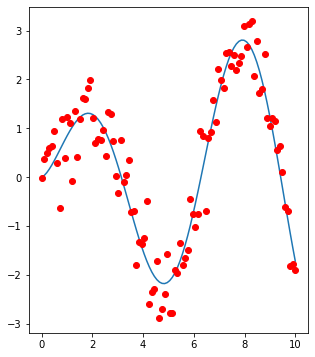

In [11]:
plt.figure(figsize=(5, 6))
y_plot = f(X, noise_amount=0)
plt.plot(X, y_plot)
plt.plot(X, y, 'ro')
plt.show()

## Ordinary least squares

In [12]:
ols = LinearRegression()
ols.fit(np.vander(X, degree), y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [14]:
y_ols = ols.predict(np.vander(X, degree))

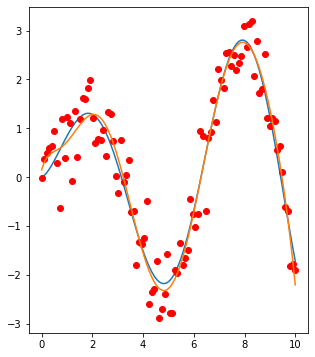

In [16]:
plt.figure(figsize=(5, 6))
y_plot = f(X, noise_amount=0)
plt.plot(X, y_plot)
plt.plot(X, y, 'ro')
plt.plot(X, y_ols)
plt.show()

## Bayesian ridge regression

In [17]:
brr = BayesianRidge()
brr.fit(np.vander(X, degree), y)

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, alpha_init=None,
              compute_score=False, copy_X=True, fit_intercept=True,
              lambda_1=1e-06, lambda_2=1e-06, lambda_init=None, n_iter=300,
              normalize=False, tol=0.001, verbose=False)

In [18]:
y_brr, y_brr_sd = brr.predict(np.vander(X, degree), return_std=True)

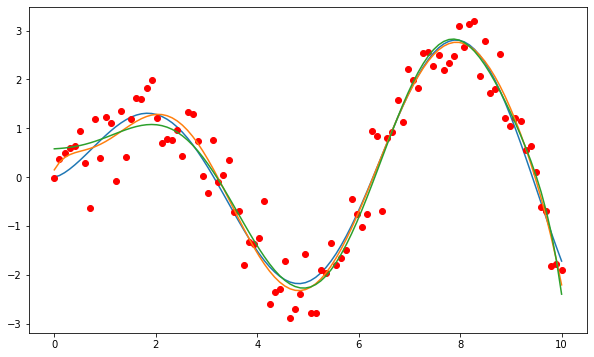

In [20]:
plt.figure(figsize=(10, 6))
y_plot = f(X, noise_amount=0)
plt.plot(X, y_plot)
plt.plot(X, y, 'ro')
plt.plot(X, y_ols)
plt.plot(X, y_brr)
plt.show()

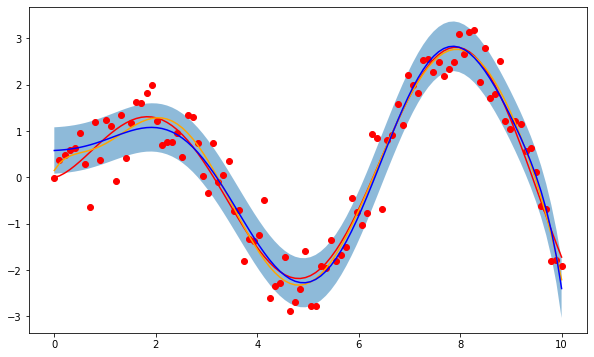

In [27]:
plt.figure(figsize=(10, 6))
y_plot = f(X, noise_amount=0)
plt.plot(X, y_plot, 'r')
plt.plot(X, y, 'ro')
plt.plot(X, y_ols, 'orange')
plt.plot(X, y_brr, 'blue')
plt.fill_between(X, y_brr-y_brr_sd, y_brr+y_brr_sd, alpha=0.5)
plt.show()

## Classical neural nets

In [87]:
class SimpleNet(nn.Module):
    def __init__(self, width):
        super().__init__()
        self.fun_1 = nn.Linear(1, width)
        self.fun_2 = nn.Linear(width, 1)

    def forward(self, x):
        x = self.fun_1(x)
        x = nn.functional.relu(x)
        x = self.fun_2(x)
        return x

In [88]:
x_torch = torch.from_numpy(X.astype(np.float32)).reshape(-1, 5, 1)
y_torch = torch.from_numpy(y.astype(np.float32)).reshape(-1, 5, 1)

In [89]:
net = SimpleNet(2000)

In [90]:
optimizer = optim.Adam(net.parameters())

In [91]:
loss = nn.MSELoss()

In [92]:
for epoch in range(2000):
    running_loss = 0
    for data_x, data_y in zip(x_torch, y_torch):
        optimizer.zero_grad()
        pred_y = net(data_x)
        current_loss = loss(data_y, pred_y)
        running_loss += current_loss
        current_loss.backward()
        optimizer.step()
    if epoch % 100 == 99:
        print('[{}] {}'.format(epoch+1, running_loss/100))

[100] 0.37279513478279114
[200] 0.3437134921550751
[300] 0.1279546618461609
[400] 0.08016404509544373
[500] 1.357505202293396
[600] 0.1253119856119156
[700] 0.09083818644285202
[800] 0.09276434779167175
[900] 0.0834299847483635
[1000] 0.08215130865573883
[1100] 0.08124569058418274
[1200] 0.07832805067300797
[1300] 0.07698434591293335
[1400] 0.08012291043996811
[1500] 0.07140156626701355
[1600] 0.07824283838272095
[1700] 0.0687899962067604
[1800] 0.07527486234903336
[1900] 0.06827833503484726
[2000] 0.07274803519248962


In [93]:
y_nn = net(x_torch.reshape(-1, 1)).detach().numpy()

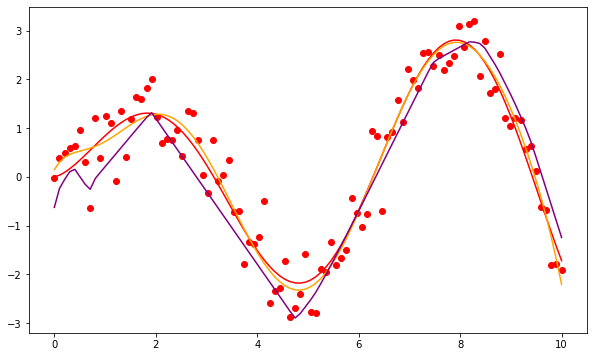

In [94]:
plt.figure(figsize=(10, 6))
y_plot = f(X, noise_amount=0)
plt.plot(X, y_plot, 'r')
plt.plot(X, y, 'ro')
plt.plot(X, y_ols, 'orange')
plt.plot(X, y_nn, 'purple')
plt.show()

## Aleatoric uncertainty

In [134]:
class AleatoricNet(nn.Module):
    def __init__(self, width):
        super().__init__()
        self.fun_1 = nn.Linear(1, width)
        self.fun_2 = nn.Linear(width, 2)

    def forward(self, x):
        x = self.fun_1(x)
        x = nn.functional.relu(x)
        x = self.fun_2(x)
        return {'mu': x[:, 0], 's': x[:, 1]}

In [135]:
aleatoric_net = AleatoricNet(2000)

In [136]:
optimizer = optim.Adam(aleatoric_net.parameters())

In [137]:
def loss(prediction, data):
    error = torch.exp(-prediction['s'])*(data-prediction['mu'])**2
    return (error/2+prediction['s']/2).mean()

In [138]:
for epoch in range(2000):
    running_loss = 0
    for data_x, data_y in zip(x_torch, y_torch):
        optimizer.zero_grad()
        pred_y = aleatoric_net(data_x)
        current_loss = loss(pred_y, data_y)
        running_loss += current_loss
        current_loss.backward()
        optimizer.step()
    if epoch % 100 == 99:
        print('[{}] {}'.format(epoch+1, running_loss/100))

[100] 0.35884177684783936
[200] 0.2802329957485199
[300] 0.17941175401210785
[400] 0.11720070987939835
[500] 0.03306949883699417
[600] 0.021908164024353027
[700] 0.04990997165441513
[800] 0.15716886520385742
[900] 0.06711195409297943
[1000] 0.08748524636030197
[1100] 0.0187066737562418
[1200] 0.08476443588733673
[1300] 0.03916655480861664
[1400] 0.03240475058555603
[1500] -0.00876650121062994
[1600] 0.21180540323257446
[1700] -0.009260779246687889
[1800] -0.007832914590835571
[1900] 0.015332874841988087
[2000] -0.009921638295054436


In [146]:
y_abn_torch = aleatoric_net(x_torch.reshape(-1, 1))
y_abn = y_abn_torch['mu'].detach().numpy()
y_abn_sd = np.exp(0.5*y_abn_torch['s'].detach().numpy())

<ipython-input-147-24448ad2e079>:8: MatplotlibDeprecationWarning: The parameter where must have the same size as x in fill_between(). This will become an error in future versions of Matplotlib.
  plt.fill_between(X, y_abn-y_abn_sd, y_abn+y_abn_sd, 'green', alpha=0.5)


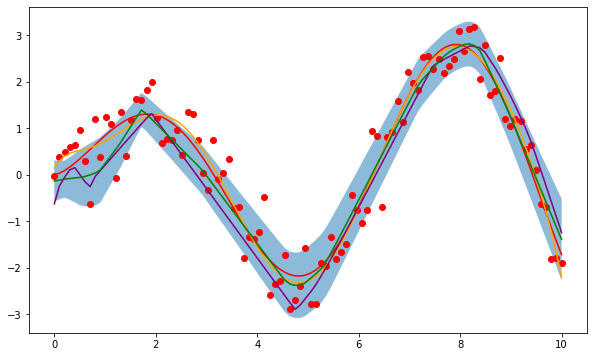

In [147]:
plt.figure(figsize=(10, 6))
y_plot = f(X, noise_amount=0)
plt.plot(X, y_plot, 'r')
plt.plot(X, y, 'ro')
plt.plot(X, y_ols, 'orange')
plt.plot(X, y_nn, 'purple')
plt.plot(X, y_abn, 'green')
plt.fill_between(X, y_abn-y_abn_sd, y_abn+y_abn_sd, 'green', alpha=0.5)
plt.show()

## Epistemic net

In [153]:
class EpistemicNet(nn.Module):
    def __init__(self, width):
        super().__init__()
        self.fun = nn.Sequential(
            nn.Linear(1, width),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(width, 1)
        )

    def forward(self, x):
        return self.fun(x)

In [154]:
epistemic_net = EpistemicNet(2000)

In [155]:
optimizer = optim.Adam(epistemic_net.parameters())

In [156]:
loss = nn.MSELoss()

In [157]:
for epoch in range(2000):
    running_loss = 0
    for data_x, data_y in zip(x_torch, y_torch):
        optimizer.zero_grad()
        pred_y = epistemic_net(data_x)
        current_loss = loss(pred_y, data_y)
        running_loss += current_loss
        current_loss.backward()
        optimizer.step()
    if epoch % 100 == 99:
        print('[{}] {}'.format(epoch+1, running_loss/100))

[100] 0.947265625
[200] 0.9439734816551208
[300] 0.7047345042228699
[400] 0.4595431983470917
[500] 0.2507462203502655
[600] 0.17255865037441254
[700] 0.1472867727279663
[800] 0.11568149924278259
[900] 0.16776977479457855
[1000] 0.15212352573871613
[1100] 0.12079065293073654
[1200] 0.13191786408424377
[1300] 0.18499664962291718
[1400] 0.11292167007923126
[1500] 0.13566230237483978
[1600] 0.11469448357820511
[1700] 0.12660226225852966
[1800] 0.10520165413618088
[1900] 0.11562098562717438
[2000] 0.13591282069683075


In [165]:
y_dropout = epistemic_net.eval()(x_torch.reshape(-1, 1)).detach().numpy()

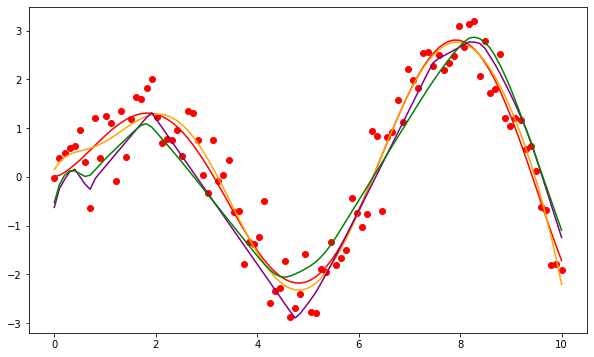

In [166]:
plt.figure(figsize=(10, 6))
y_plot = f(X, noise_amount=0)
plt.plot(X, y_plot, 'r')
plt.plot(X, y, 'ro')
plt.plot(X, y_ols, 'orange')
plt.plot(X, y_nn, 'purple')
plt.plot(X, y_dropout, 'green')
plt.show()

In [167]:
epistemic_net

EpistemicNet(
  (fun): Sequential(
    (0): Linear(in_features=1, out_features=2000, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=2000, out_features=1, bias=True)
  )
)

In [177]:
mc_y = np.concatenate([epistemic_net.train()(x_torch.reshape(-1, 1)).detach().numpy() for __ in range(50)], axis=1)

In [179]:
y_ebn = mc_y.mean(axis=1)
y_ebn_sd = mc_y.std(axis=1)

<ipython-input-181-0943d23e1882>:8: MatplotlibDeprecationWarning: The parameter where must have the same size as x in fill_between(). This will become an error in future versions of Matplotlib.
  plt.fill_between(X, y_ebn-y_ebn_sd, y_ebn+y_ebn_sd, 'green', alpha=0.5)


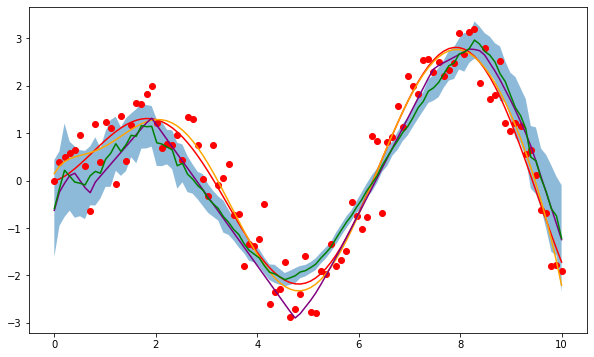

In [181]:
plt.figure(figsize=(10, 6))
y_plot = f(X, noise_amount=0)
plt.plot(X, y_plot, 'r')
plt.plot(X, y, 'ro')
plt.plot(X, y_ols, 'orange')
plt.plot(X, y_nn, 'purple')
plt.plot(X, y_ebn, 'green')
plt.fill_between(X, y_ebn-y_ebn_sd, y_ebn+y_ebn_sd, 'green', alpha=0.5)
plt.show()